In [1]:
#===================================#
#   Tool to generate simulations    #
#   of a Toy Dark halo for          #
#   On observation modes            #
#===================================#

#-------------------------------------
#Imports
#-------------------------------------

import gammalib
import ctools
import cscripts

import numpy as np
import os
import time

from ctaAnalysis.dmspectrum.dmflux import dmflux_anna
import ctaAnalysis.tools.createmodels as cmodels

%matplotlib inline

In [2]:
# This function create a GModel container for the bkg
# Based on the XML examples you can find in $CTOOLS/share/models
def _gen_bkgmodel() :
    """
    Create bkg model. This model assume that the bkg type
    is modeled by the IRF provided by the user.

    Return
    ------
    Gmodel for bkg
    """

    #   XmlElement for the spectrum part
    spectrum = gammalib.GXmlElement( 'spectrum type="PowerLaw"' )

    #   Append parameters for the powerlaw
    spectrum.append( 'parameter name="Prefactor" value="1" error="0" ' +
        'scale="1" min="0.001" max="1000" free="1"' )
    spectrum.append( 'parameter name="Index" value="0" error="0" ' +
        'scale="1" min="-5" max="5" free="1"' )
    spectrum.append( 'parameter name="Scale" value="1" ' +
        'scale="1000000" min="0.01" max="1000" free="0"' )

    #   XmlElement for source
    bkgxml = gammalib.GXmlElement( 'source name="CTABackgroundModel" ' +
        'type="CTAIrfBackground" instrument="CTA"' )

    #   Append spectral part
    bkgxml.append( spectrum )

    #   Then create GModel
    bkgmodel = gammalib.GCTAModelIrfBackground( bkgxml )

    return bkgmodel


In [4]:
#   Parameters for pointSource Model of the Toy Dark halo

srcname     = 'ToyDarkHalo'
modtype     = 'PointSource'
spectype    = 'FileFunction'
dmmass      = 1.e+3 # in GeV
channel     = 'Tau'
#   File to save the gamma-ray flux
fname       = '{0}_dmflux_mass{1}_ch{2}.txt'.format( srcname , dmmass , channel )
ra          = 188.0   # in degrees
dec         = 12.5    # in degrees
sigmav      = 3.6e-26 # in cm**3 per s
astrofactor = np.power( 10 , 18.7 ) #   Dark Halo
redshift    = 0.02
eblmodel    = 'dominguez'
hasEW       = True
emin        = 30.0          #   GeV
emax        = 0.99 * dmmass #   GeV
minval      = 0.0
maxval      = 1.e+10


In [5]:
#   Parameters for CTA Observation
tstart     = 0.0
tfinish    = 5.0 * 3600 # 5 h times 3600 sec
sim_emin   = 0.03  #  TeV
sim_emax   = 100.0 #  TeV
ROI_radius = 3.0   #  degrees
irf        = 'North_z20_5h' #  Toy Dark Halo
caldb      = 'prod3b-v2'


In [6]:
#   Compute DM flux
#   create instance of dmspectrum class to compute flux
dmflux   = dmflux_anna( sigmav , astrofactor , dmmass , emin , emax ,
    channel , redshift , eblmod=eblmodel , has_EW=hasEW )


In [7]:
#   Get flux
dphide   = dmflux.flux()

#   Get energies used to compute the flux
energies = dmflux.energy

#   Save data to fname
data     = np.array( ( energies * 1.e+3 , dphide * 1.e-3 ) ).transpose()
np.savetxt( fname , data , fmt='%.5e' , delimiter=' ' )


In [8]:
#   Plotting the gamma-ray flux
import matplotlib.pyplot as plt

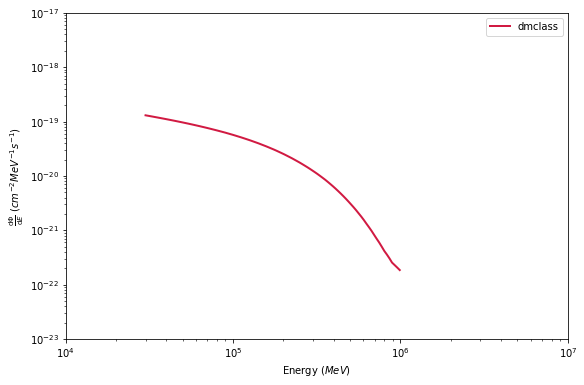

In [12]:
fig , ax = plt.subplots( figsize=( 9 , 6 ) )

ax.plot( dmflux.energy * 1.e+3 , dphide * 1.e-3 , color=( 0.82 , 0.10 , 0.26 ) , lw=2 , label='dmclass' )

ax.set_xlim( 1.e+4 , 1.e+7 )
ax.set_ylim( 1.e-23 , 1.e-17 )
ax.set_xscale( 'log' )
ax.set_yscale( 'log' )
ax.set_xlabel( 'Energy $(MeV)$' )
ax.set_ylabel( '$\\frac{\\mathrm{d}\\Phi}{\\mathrm{d}E}$ ($cm^{-2} MeV^{-1} s^{-1}$)' )

ax.legend( loc='best' , prop={ 'size': 10 } )

plt.show()

In [13]:
#   Generate GModelSky for Toy Dark Halo
#   Create spectral GXmlElement
xmlspec = cmodels.dm_spectral_xml( spectype , fname , minval=minval , maxval=maxval )

#   Create spatial GXmlElement
xmlspat = cmodels.dm_pointsource_xml( ra , dec )

#   Create GModel Container
dmmod        = cmodels.DMModel( srcname , modtype , xmlspec , xmlspat )
thisdmmodel  = dmmod.model()


In [14]:
#   Create background model
thisbkgmodel = _gen_bkgmodel()


In [15]:
#   GModels source and append dm and bkg models
dmmodels = gammalib.GModels()
dmmodels.append( thisdmmodel )
dmmodels.append( thisbkgmodel )

#   Check the dmmodels container
print( dmmodels )

=== GModels ===
 Number of models ..........: 2
 Number of parameters ......: 8
=== GModelSky ===
 Name ......................: ToyDarkHalo
 Instruments ...............: all
 Test Statistic ............: Computation requested
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "FileFunction" * "Constant"
 Number of parameters ......: 4
 Number of spatial par's ...: 2
  RA .......................: 188 [-360,360] deg (fixed,scale=1)
  DEC ......................: 12.5 [-90,90] deg (fixed,scale=1)
 Number of spectral par's ..: 1
  Normalization ............: 1 +/- 0 [0,10000000000]  (free,scale=1,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)
 Number of scale par's .....: 0
=== GCTAModelIrfBackground ===
 Name ......................: CTABackgroundModel
 Instruments ...............: CTA
 Observation identifiers ...: all
 Model type ................: "Pow

In [16]:
#   GModels source and append dm and bkg models
dmmodels = gammalib.GModels()
dmmodels.append( thisdmmodel )
dmmodels.append( thisbkgmodel )

#   The simulations are performed using default tools from
#   cscripts.tools package
#   Setting the observation in On-mode

#   GSkyDir
pntdir = gammalib.GSkyDir()
pntdir.radec_deg( ra , dec )


In [17]:
thisobsid = 'DM001'

#   Set observation
dmobs = cscripts.obsutils.set_obs( pntdir , tstart=tstart , 
                                  duration=tfinish , emin=sim_emin , emax=sim_emax , rad=ROI_radius ,
                                  irf=irf ,caldb=caldb , obsid=thisobsid )

#   Create GObservations container to append the dm observation
obslist = gammalib.GObservations()

#   Append observation
obslist.append( dmobs )

#   Append models
obslist.models( dmmodels )

In [18]:
#   Start simulation
#   You can change the parameter nthreads according to 
#   the number of cores available in your machine
obssim = cscripts.obsutils.sim( obslist , log=False , debug=False ,
                               chatter=4 , edisp=False , seed=int( time.time() ) , nthreads=1 )

In [19]:
#   cscripts.obsutils.sim return a gammalib.GObservations container
#   but, in order to save the fits file, I must to get obs from the
#   container.
fitsname = '{0}_dmflux_mass{1}_ch{2}_{3}.fits'.format( srcname , dmmass , channel , thisobsid )
dmobs  = obssim[ 0 ]
dmobs.save( fitsname )


In [20]:
#   Take a look at the simulation
#   This is taken from the HOW-to examples: 
#   http://cta.irap.omp.eu/ctools/users/tutorials/howto/howto_advanced_python_fitting.html

skymap = ctools.ctskymap()
skymap['inobs']       = fitsname
skymap['emin']        = sim_emin
skymap['emax']        = sim_emax
skymap['nxpix']       = 40
skymap['nypix']       = 40
skymap['binsz']       = 0.02
skymap['proj']        = 'TAN'
skymap['coordsys']    = 'CEL'
skymap['xref']        = ra
skymap['yref']        = dec
skymap['bkgsubtract'] = 'IRF'
skymap['caldb']       = caldb
skymap['irf']         = irf
skymap.run()

/usr/local/anaconda3/envs/ctasv1_7_1/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  if sys.path[0] == '':


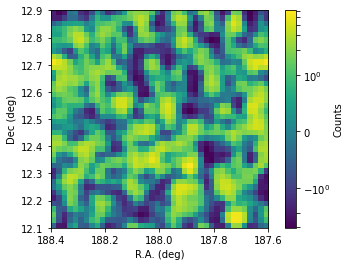

In [21]:
# Slightly smooth the map for display to suppress statistical fluctuations
skymap.skymap().smooth('GAUSSIAN',0.02)

from matplotlib.colors import SymLogNorm
# The SymLogNorm scale is a Log scale for both positive and negative values
# and is linear within a certain range around 0

ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
           extent=[ra+0.02*20,ra-0.02*20,dec-0.02*20,dec+0.02*20],
           # boundaries of the coord grid
           norm=SymLogNorm(1)) # the scale will be linear within +-1 count
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')